In [1]:
import sys
sys.path.append('..')

import torch
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

from fastai.vision import Learner, accuracy
from fastai.basic_data import DataBunch

from model.dense import Dense
from experiment_setup import build_estimator
from uncertainty_estimator.masks import build_masks, build_mask, DEFAULT_MASKS
# from experiments.utils.fastai import Inferencer 

In [2]:
border = 1.2
xx, yy = np.meshgrid(np.linspace(-border, border, 200), np.linspace(-border, border, 200))
x_val = np.vstack((xx.ravel(), yy.ravel())).T
epochs = 50
layers = (2, 100, 100, 100, 2)


In [3]:
def xor(points, noise_level=0.):
    rng = np.random
    x = 2*rng.random((points, 2)) - 1
    noised_x = x + noise_level * rng.randn(points, 2)
    y = np.logical_xor(noised_x[:, 0] > 0, noised_x[:, 1] > 0)
    return x, y


def train(x, y):
    loss_func = torch.nn.CrossEntropyLoss()
    model = Dense(layers, dropout_rate=0.5)

    train_ds = TensorDataset(torch.FloatTensor(x), torch.LongTensor(y))
    data = DataBunch.create(train_ds, train_ds, bs=10)

    learner = Learner(data, model, metrics=accuracy, loss_func=loss_func)

    learner.fit_one_cycle(epochs)
    return model

def eval(model, x, y, method='basic_bern', noise_level=0):
    t_val = torch.FloatTensor(x_val).cuda()
    mask = build_mask(method)
    estimator = build_estimator('bald_masked', model, dropout_mask=mask, num_classes=2, dropout_rate=0.5)
    estimations = sigmoid(estimator.estimate(t_val))
    
    # estimations = model(t_val)[np.arange(len(t_val)), ]
    Z = estimations.reshape(xx.shape)
    plt.figure()
    plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=plt.cm.gray, edgecolors=(0, 0, 0))
    plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.RdBu_r)
    plt.title(f"Xor with noise {noise_level} by {method}")
    plt.savefig(f"data/xor/{method}_{noise_level}.png")
    plt.show()


49        0.167912    0.145382    0.940000  00:00               
epoch     train_loss  valid_loss  accuracy  time    
      0         0.690906    0.681872    0.700000  00:00     
      1         0.682542    0.675215    0.594000  00:00     
      2         0.680019    0.661841    0.620000  00:00     
      3         0.668646    0.634752    0.630000  00:00     
      4         0.633880    0.562648    0.826000  00:00     
      5         0.567036    0.408596    0.884000  00:00     
      6         0.470546    0.283114    0.882000  00:00     
      7         0.423313    0.288777    0.858000  00:00     
      8         0.383225    0.235318    0.906000  00:00     
      9         0.319865    0.261526    0.868000  00:00     
      10        0.314436    0.185685    0.914000  00:00     
      11        0.354109    0.216559    0.902000  00:00     
      12        0.289650    0.218724    0.914000  00:00     
      13        0.298774    0.216422    0.904000  00:00     
      14        0.296535    

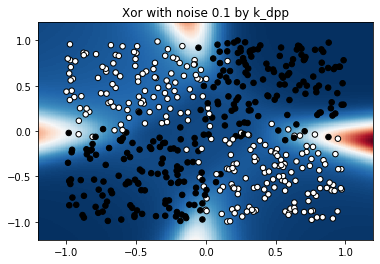

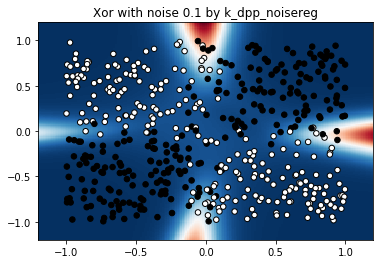

In [ ]:
for noise_level in [0, 0.1, 0.2, 0.3]:
    for mask_name in DEFAULT_MASKS:
        x, y = xor(500, noise_level)
        model = train(x, y)
        eval(model, x, y, mask_name, noise_level)